# Example 1: Ground Motion Records Processing for Intensity Measure Extraction

## Introduction

This Jupyter Notebook provides a workflow for reading ground motion record files and extracting distinct intensity measure (IM) levels across various IM types. Ground motion intensity measures are essential parameters that characterize the ground shaking and potential impact of seismic records on structures. By extracting these measures, we can better understand the demand imposed by ground motions on structural systems and eventually characterise a probabilistic demand-intensity model to building classes under investigation.

The main goals of this notebook are:

1. **Read and Process Ground Motion Records**: Load seismic record files. The files should be in a format that allows easy parsing and processing. In this example, each ground-motion record consists of separate accelerations and time csv files.

2. **Extract Intensity Measure (IM) Levels**: For each ground motion record, calculate various intensity measures, such as:
   - Peak Ground Acceleration (PGA)
   - Peak Ground Velocity (PGV)
   - Peak Ground Displacement (PGD)
   - Spectral Acceleration (SA) at specified periods (0.3s, 0.6s, 1.0s)
   - Average Spectral Acceleration (AvgSA) considering a range of 0.2T to 1.5T at specified periods (0.3s, 0.6s, 1.0s)
   - Arias Intensity, Significant Duration (D595)
  
Please note that the library used "intensityMeasures" is able to characterise more intensity measure and is always subject for updating to reflect state-of-the-art IM inclusion.

3. **Organize and Export Results**: Organize the extracted IM levels for each record, summarizing the results for analysis and potential use in structural modeling and assessment studies. The results are stored into a dictionary type variable and exported into a pickle file. 

This notebook provides a step-by-step guide to process ground motion records efficiently, extract a wide range of IM types, and present the data in an accessible format. Basic knowledge of earthquake engineering and data processing is recommended to fully utilize the material in this notebook.

---

## Prerequisites

To run this notebook successfully, the following "non-native" Python packages are required:
-  eqsig: A python package for seismic signal processing, installable via: "pip install eqsig"
    - Reference: https://eqsig.readthedocs.io/en/latest/

---

## Workflow Overview

1. **Load Libraries and Input Files**: Import the necessary libraries and read in ground motion record files.
2. **Process Time-Series Data and Extract Intensity Measures (IMs)**: Parse the ground motion records and prepare them for IM extraction to compute various IMs for each ground motion, storing results in a structured format.
3. **Organize and Export IM Data**: Organize the extracted IM levels in a summary table, with options to export the data for further analysis or modeling purposes.

By the end of this notebook, users will have a flexible and reusable script for extracting a variety of intensity measures from ground motion records, enabling enhanced seismic analysis and research applications.

Let’s start by loading the required libraries and reading in the ground motion records.

# Input Parameters

In [38]:
### [REQUIRED INPUT] Define the main directory
main_directory = 'C:/Users/m.nafeh/Documents/GitHub/vulnerability-toolkit' # Replace this line with the directory you cloned the scripts to

### [REQUIRED INPUT] Define required intensity measure types
IMTs = ['PGA','PGV','PGD',
        'SA(0.3s)','SA(0.6s)','SA(1.0s)',
        'AvgSA(0.3s)','AvgSA(0.6s)','AvgSA(1.0s)',
        'AI','D595']

# Initialize Libraries and Modules

In [40]:
import time
import sys
import warnings
import os

warnings.filterwarnings("ignore") # (I don't condone it, but we use this to suppress all warnings)
# Import vulnerability-toolkit libraries
sys.path.insert(1, f'{main_directory}/src')
from im_calculator import *
from utilities import *
from plotter import *

start = time.time()

# Load Input Files and Initialise Dictionary

In [68]:
# Load the records directory which contains two folders where the time and acceleration arrays of each ground-motion record are stored
gmDir = f'{main_directory}/example/in/records' # Records directory path

# Fetch the ground-motion records files
gmrs = sorted_alphanumeric(os.listdir(f'{gmDir}/acc'))

# Initialise the storage dictionary and name the "keys" in accordance with the defined IMT
ims = {}
for i, currentIMT in enumerate(IMTs):    
    ims[currentIMT] = []

# Process Time-Series Data and Extract Intensity Measure Levels

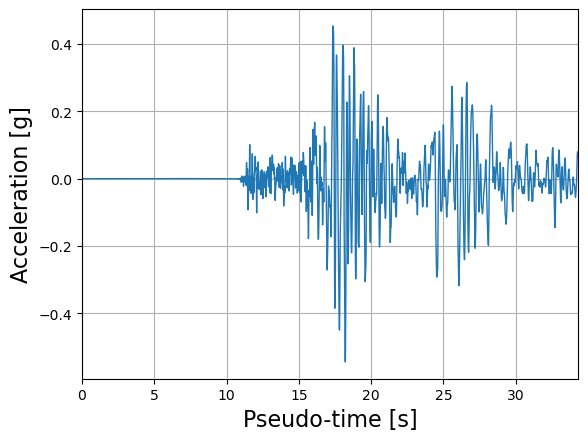

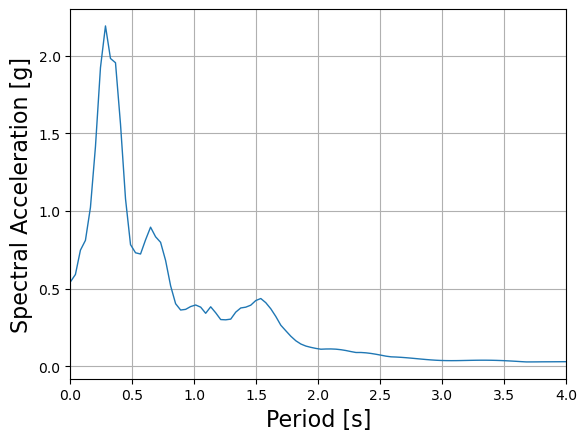

In [72]:
# Loop over the files
for i in range(len(gmrs)):

    # Get the acceleration files
    fnames = [f'{gmDir}/acc/{gmrs[i]}']
    fdts = f'{gmDir}/dts/dts_{i}.csv'
    
    # define the acceleration time-history
    current_acc = pd.read_csv(fnames[0]).to_numpy().flatten()
    current_dts = pd.read_csv(fdts)
    # define the time-step of the acceleration time-history
    dt_gm = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].loc[0]
    
    # Initialise the intensity measure fetching object
    im = im_calculator(current_acc,dt_gm) # The class "intensityMeasure" is initialised using the acceleration array and the time-step scalar value
    
    # Get the 5% and 95% time stamps to use as xlim
    _, t_end  = eqsig.im.calc_sig_dur_vals(current_acc, dt_gm, start=0.05, end=0.95, se=True)
    
    # Plot the time-history only for the first iteration (= file)
    if i==0:
        plt.plot(current_dts, current_acc, lw=LINEWIDTH_3)
        plt.xlabel('Pseudo-time [s]', fontsize= FONTSIZE_1)
        plt.ylabel('Acceleration [g]', fontsize = FONTSIZE_1)
        plt.grid(visible=True, which='major')
        plt.grid(visible=True, which='minor')
        plt.xlim([0.00, t_end+5])
        plt.show()
    
    ### Get acceleration response spectrum and other ims
    prd, sas = im.get_spectrum()
    pga, pgv, pgd = im.get_amplitude_ims()
    ai, cav, d595 = im.get_duration_ims()
    
    if i==0:
        plt.plot(prd, sas, lw=LINEWIDTH_3)
        plt.xlabel('Period [s]', fontsize= FONTSIZE_1)
        plt.ylabel('Spectral Acceleration [g]', fontsize = FONTSIZE_1)
        plt.grid(visible=True, which='major')
        plt.grid(visible=True, which='minor')
        plt.xlim([0.00, 4.00])
        plt.show()

    ### Calculate the intensity measures
    for j, currentIMT in enumerate(IMTs):

        # NOTE: IGNORE THE WARNINGS DISPLAYED ON THE SCREEN
        # PLEASE VISIT THE DOCUMENTATION AVAILABLE ON THE GITHUB REPOSITORY FOR MORE INFORMATION ON THE "intensityMeasure" CLASS
        
        if currentIMT == 'PGA':
            ims[currentIMT].append(pga) # The get_amplitude_ims() method returns the amplitude-based IMs (i.e., PGA, PGV and PGD and in this order)
        elif currentIMT == 'PGV':
            ims[currentIMT].append(pgv) # The get_amplitude_ims() method returns the amplitude-based IMs (i.e., PGA, PGV and PGD and in this order)
        elif currentIMT == 'PGD':
            ims[currentIMT].append(pgd) # The get_amplitude_ims() method returns the amplitude-based IMs (i.e., PGA, PGV and PGD and in this order)
                        
        elif currentIMT == 'SA(0.3s)':
            ims[currentIMT].append(im.get_sa(prd,sas,0.3)) # The get_sa(periods, spectral_accelerations, SYSTEM_PERIOD) method returns the spectral acceleration at the designated SYSTEM PERIOD (in this case 0.3s)                                                                
        elif currentIMT == 'SA(0.6s)':
            ims[currentIMT].append(im.get_sa(prd,sas,0.6)) # The get_sa(periods, spectral_accelerations, SYSTEM_PERIOD) method returns the spectral acceleration at the designated SYSTEM PERIOD (in this case 0.6s)
        elif currentIMT == 'SA(1.0s)':
            ims[currentIMT].append(im.get_sa(prd,sas,1.0)) # The get_sa(periods, spectral_accelerations, SYSTEM_PERIOD) method returns the spectral acceleration at the designated SYSTEM PERIOD (in this case 1.0s)

        elif currentIMT == 'AvgSA(0.3s)':
            ims[currentIMT].append(im.get_saavg(prd,sas,0.3)) # The get_saavg(periods, spectral_accelerations, SYSTEM_PERIOD) method returns the average spectral acceleration ranging from 0.2 to 1.5 the designated SYSTEM PERIOD (in this case 0.3s)                                                                
        elif currentIMT == 'AvgSA(0.6s)':
            ims[currentIMT].append(im.get_saavg(prd,sas,0.6)) # The get_saavg(periods, spectral_accelerations, SYSTEM_PERIOD) method returns the average spectral acceleration ranging from 0.2 to 1.5 the designated SYSTEM PERIOD (in this case 0.6s)
        elif currentIMT == 'AvgSA(1.0s)':
            ims[currentIMT].append(im.get_saavg(prd,sas,1.0)) # The get_saavg(periods, spectral_accelerations, SYSTEM_PERIOD) method returns the average spectral acceleration ranging from 0.2 to 1.5 the designated SYSTEM PERIOD (in this case 1.0s)
            
        elif currentIMT == 'AI':
            ims[currentIMT].append(ai) # The get_duration_ims() method returns the duration-based IMs (i.e., Arias Intensity, Significant Duration (5-75) and Significant Duration (5-95) and in this order) 
        elif currentIMT == 'D595':
            ims[currentIMT].append(d595) # The get_duration_ims() method returns the duration-based IMs (i.e., Arias Intensity, Significant Duration (5-75) and Significant Duration (5-95) and in this order)

# Organize and Export IM Data

In [80]:
# Export to pickle format using the export_to_pkl function imported from utilities
export_to_pkl(f'{gmDir}/ims.pkl', ims)

In [82]:
end = time.time()
print('Elapsed Time:', (end - start)/60, 'minutes')

Elapsed Time: 13.611842775344849 minutes
